In [7]:
import pyvisa
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
from scipy import optimize
import scipy.integrate as integrate
import scipy.special as special
from scipy.signal import find_peaks
import h5py
import time
import tqdm
from typing import List, Tuple, Sequence

#### System parameters

In [8]:
N = 15       # number of loops
lc = 0.1     # magnetic core length / m
l = 7e-2
w = 18e-6 * 4
ur = 70000
u0 = 4* np.pi * 1e-7
u = ur * u0
Ac = l * w   # cross-sectional area / m2

In [9]:
def get_data(fname):
    z = []
    B = []
    for i in range(1, 6):
        with h5py.File(fname, "a") as f:
            dset = f[f"R-{i}"]
            B0, B90, B180, B270, B360 = [dset[:, i] * 100 for i in range(5)]
            Bread = [B0, B90, B180, B270, B360]
            posi = int(dset.attrs["position"])
            B.append(Bread)
            z.append(posi)
    return B, z

In [18]:
fname = "C:\\Users\\yuanhang.yang\\Documents\\GitHub\\new_cavity\\windfreak\\osci_data\\hystersis_2_28_2024.hdf"
Vin = []
Vpick = []
Vamp = [0.5,1,2,5,10]
with h5py.File(fname, "a") as f:
    for i in range(1, 6):
        dset = f[f"10-{i}"]
        Vin.append(dset[0])
        Vpick.append(dset[1])

Text(0, 0.5, 'voltage / V')

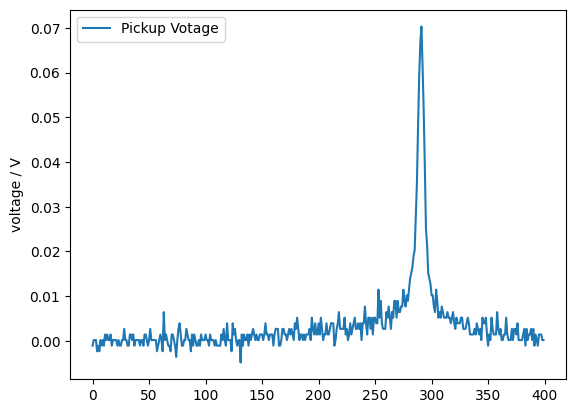

In [35]:
#plt.plot(Vin[2], label =  "Voltage on Oscillope")
plt.plot(Vpick[4][600:1000], label =  "Pickup Votage")
plt.legend()
plt.ylabel("voltage / V")

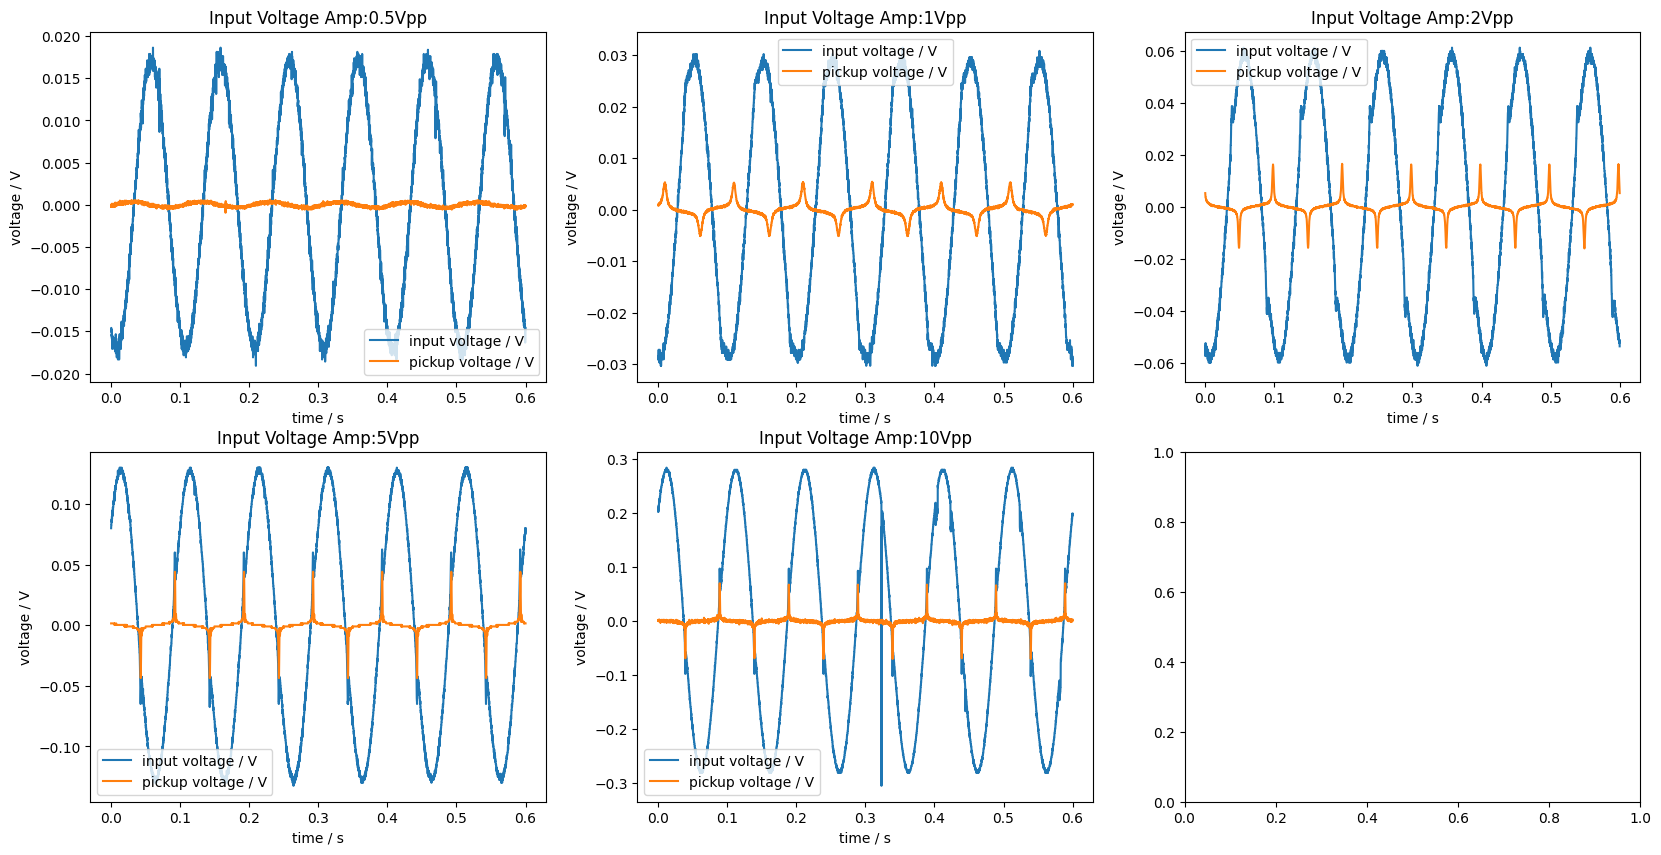

In [12]:
fig, ax = plt.subplots(2,3,figsize=(20, 10))
tim_mea = np.linspace(0,0.6,6000)
for i in range(5):
    if i < 3 :
        ax[0,i].plot(tim_mea,Vin[i], label = "input voltage / V")
        ax[0,i].plot(tim_mea,Vpick[i], label = "pickup voltage / V")
        ax[0,i].set_title("Input Voltage Amp:" + str(Vamp[i])+"Vpp")
        ax[0,i].set_xlabel("time / s")
        ax[0,i].set_ylabel("voltage / V")
        ax[0,i].legend()
    else:
        ax[1,i-3].plot(tim_mea,Vin[i], label = "input voltage / V")
        ax[1,i-3].plot(tim_mea,Vpick[i], label = "pickup voltage / V")
        ax[1,i-3].set_title("Input Voltage Amp:" + str(Vamp[i])+"Vpp")
        ax[1,i-3].set_xlabel("time / s")
        ax[1,i-3].set_ylabel("voltage / V")
        ax[1,i-3].legend()

In [13]:
Vin = []
Vpick = []
fre =  ["50","100","500","1000","5000","20000"]
with h5py.File(fname, "a") as f:
    for i in fre:
        dset = f[f"{i}-1"]
        Vin.append(dset[0])
        Vpick.append(dset[1])

KeyError: "Unable to open object (object '50-1' doesn't exist)"

IndexError: list index out of range

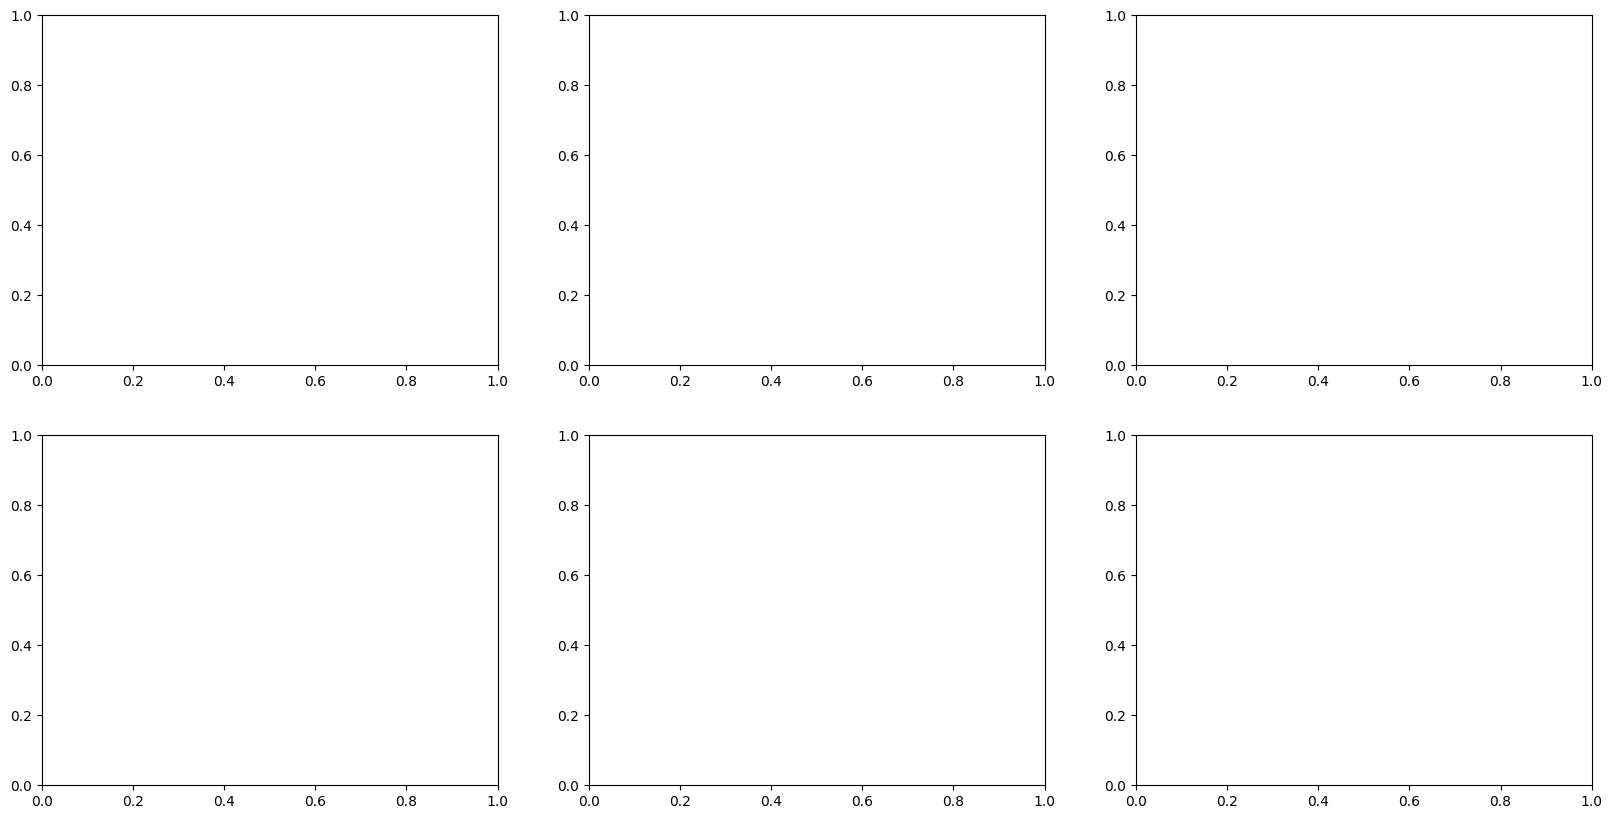

In [14]:
fig, ax = plt.subplots(2,3,figsize=(20, 10))
tim_mea = []
for i in range(6):
    tim_mea.append(np.linspace(0,6/int(fre[i]),6000))
for i in range(6):
    if i < 3 :
        ax[0,i].plot(tim_mea[i],Vin[i], label = "input voltage / V")
        ax[0,i].plot(tim_mea[i],Vpick[i], label = "pickup voltage / V")
        ax[0,i].set_title("Input frequency:" + str(fre[i])+"Hz")
        ax[0,i].set_xlabel("time / s")
        ax[0,i].set_ylabel("voltage / V")
        ax[0,i].legend()
    else:
        ax[1,i-3].plot(tim_mea[i],Vin[i], label = "input voltage / V")
        ax[1,i-3].plot(tim_mea[i],Vpick[i], label = "pickup voltage / V")
        ax[1,i-3].set_title("Input frequency:" + str(fre[i])+"Hz")
        ax[1,i-3].set_xlabel("time / s")
        ax[1,i-3].set_ylabel("voltage / V")
        ax[1,i-3].legend()

fig.suptitle("Input: 0.5Vpp")

In [15]:
def test_func(x, a ,b, c):
    return a * np.sin(b * x + c)

def sin_fit(raw_data, Vset, fre, time_factor):
    x_data = np.linspace(0 , 6/fre, len(raw_data))
    y_data = raw_data
    params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,p0=[0.5,time_factor*fre,0])
    plt.plot(x_data, y_data, '.', label='Data')
    plt.plot(x_data, test_func(x_data, params[0], params[1],params[2]),label='Fitted function',color = "r")
    plt.legend(loc='best')
    plt.show()
    return params, x_data

In [16]:
amp_fit = []
fre_fit = []
phase_fit = []
V_SGamp = []
for i in range(5):
    param,x = sin_fit(Vin[i],Vamp[i],10,6)
    amp_fit.append(param[0])
    fre_fit.append(param[1])
    phase_fit.append(param[2])
    if param[0] > 0:
        V_SGamp.append((2 * Vamp[i] - 2*abs(param[0]))/2)
    else:
        V_SGamp.append((-1* (2 * Vamp[i] - 2*abs(param[0])))/2)

IndexError: list index out of range

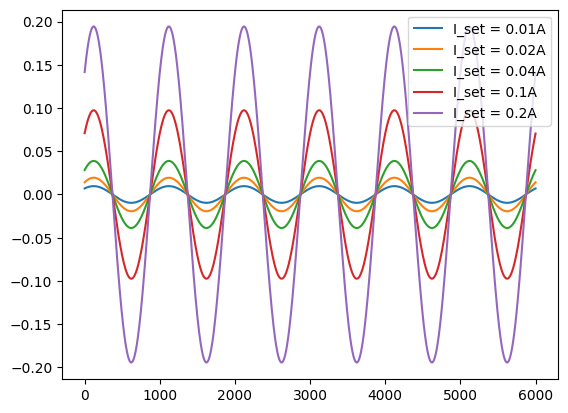

In [ ]:
I = []
I_set = np.array(Vamp)/50
for i in range(5):
    V_SG = test_func(x, V_SGamp[i], param[1],param[2])
    I.append(V_SG /50)
    plt.plot(I[i], label  = "I_set = "+ str(I_set[i]) + "A")
    plt.legend()


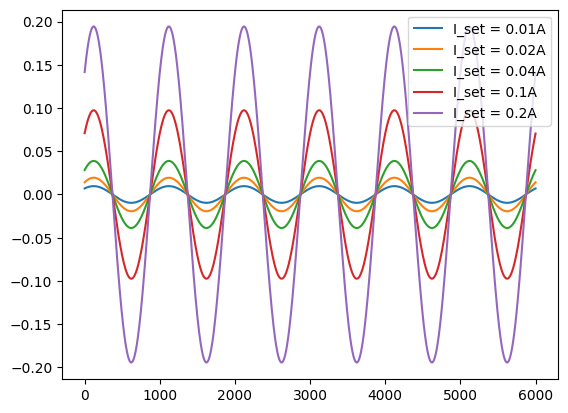

In [ ]:
I = []
I_set = np.array(Vamp)/50
I_SGamp = np.array(V_SGamp)/50
for i in range(5):
    V_SG = test_func(x, V_SGamp[i], param[1],param[2])
    I.append(V_SG /50)
    plt.plot(I[i], label  = "I_set = "+ str(I_set[i]) + "A")
    plt.legend()

    

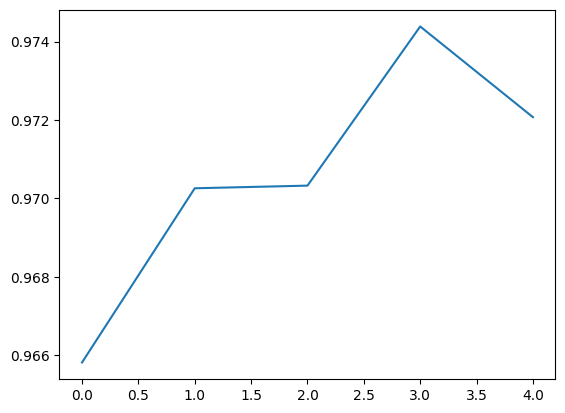

In [ ]:
Vratio = [b / m for b,m in zip(I_SGamp, I_set)]
plt.plot(Vratio)

In [ ]:
plt.plot(I[4][0:600])
plt.plot(Vpick[4][0:600])
plt.xlabel()

NameError: name 'plt' is not defined

[2.652692880171041e-16, -7.579122514774402e-16, 9.094947017729283e-16, -3.0316490059097607e-16, 6.063298011819521e-16]


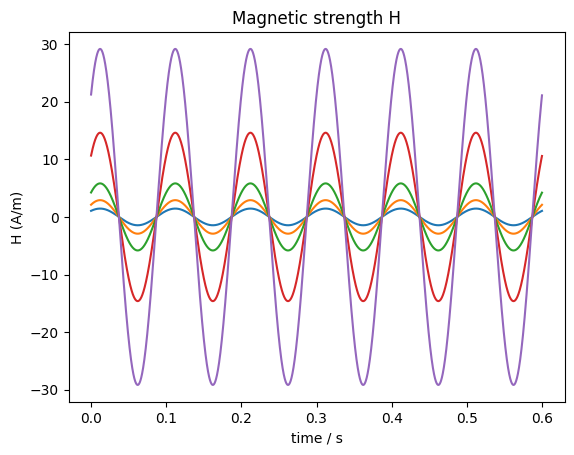

In [ ]:
T = x
T_be = 1000e-4     # Begin time period
T_end = 2000e-4
T_per = 0.1            # Period length
dt = 1e-4              # time interval
Nt = 1000              # #of data points for integral
H = []
B = []
B_int = []
peaks_find = []
mean = []
for i in range(5):
    H.append(np.array(I[i]) * N / lc)         # Magnetic field strength
    plt.plot(T,H[i])
    plt.xlabel("time / s")
    plt.ylabel("H (A/m)")
    plt.title("Magnetic strength H")
dB = np.array(Vpick)/Ac/N

for i in range(len(dB)):
    peaks,_ = find_peaks(dB[i],distance=500,height= max(dB[i])*0.7)
    peaks_find.append(peaks)
    mean.append(np.mean(dB[i]))


for i in range(5):
    Bini = [0]
    for a in dB[i][peaks_find[i][0]:peaks_find[i][-1]]:
        Bini.append(Bini[-1] + ( a - mean[i]) * dt )
    B.append(Bini[1:])

print(mean)

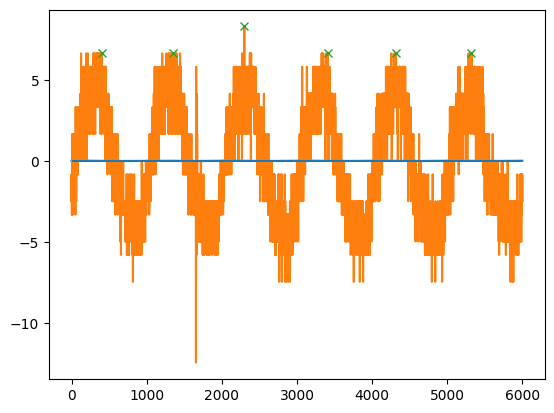

In [ ]:
def plot_sub(loopn,sp,ep):
    plt.plot(I[loopn][sp:ep])
    plt.plot(dB[loopn][sp:ep])
    plt.plot(peaks_find[loopn],dB[loopn][peaks_find[loopn]],"x")
    plt.hlines(xmin=0,xmax=ep - sp,y=0)

plot_sub(0,0,6000)

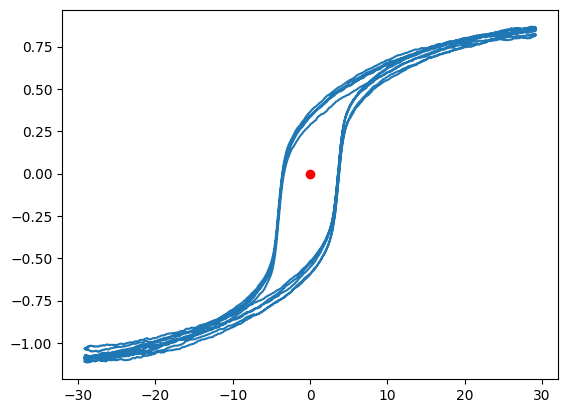

In [ ]:
plt.plot(H[4][peaks_find[4][0]:peaks_find[4][-1]],B[4])
plt.plot(0,0,"o",color = "r")

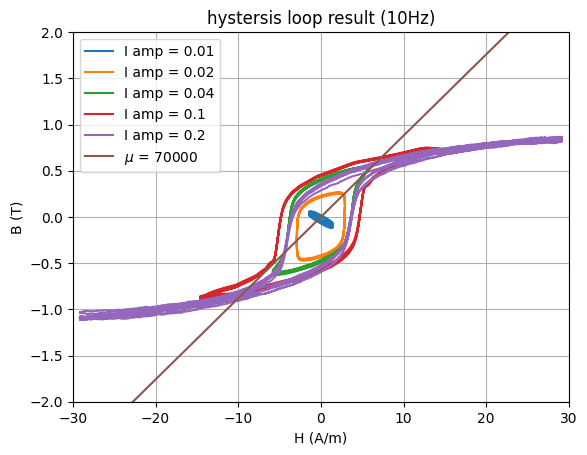

In [ ]:
H_line = np.linspace(-30,30,12)
B_the = H_line * u
B_amped = []
for i in range(5):
    plt.plot(H[i][peaks_find[i][0]:peaks_find[i][-1]],B[i], label = "I amp = " + str(Vamp[i]/50))
    #plt.plot(H[i],B[i]-np.mean(B[i]), label = "I amp = " + str(Vamp[i]/50))
    #plt.plot(H[i],B_amped[i]-np.mean(B_amped[i]), label = "I amp = " + str(Vamp[i]/50))
plt.plot(H_line,B_the, label = r"$\mu$ = 70000")
#plt.plot(0,0,"o",color = "r")
plt.xlim([-30,30])
plt.ylim([-2,2])
plt.xlabel("H (A/m)")
plt.ylabel("B (T)")
plt.title("hystersis loop result (10Hz)")
plt.grid(True)
plt.legend()

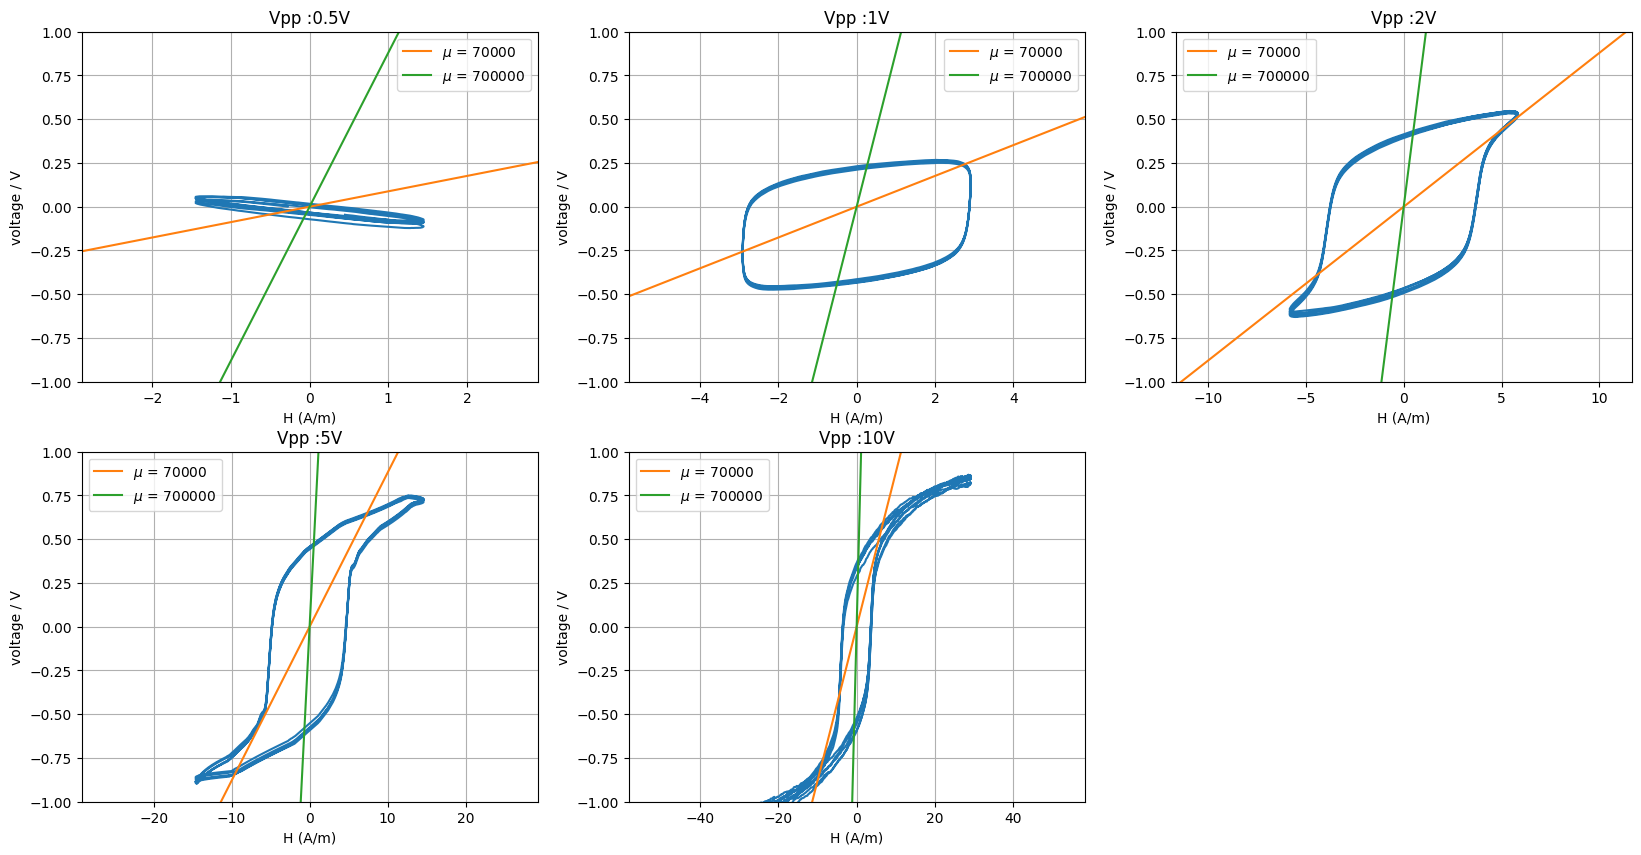

In [ ]:
H_line = np.linspace(-30,30,12)
B_the70 = H_line * u
B_the700 = B_the70 * 10
fig, ax = plt.subplots(2,3,figsize=(20, 10))
for i in range(5):
    if i < 3 :
        # ax[0,i].plot(H[i][peaks_find[i][0]:peaks_find[i][-1]],B[i]-np.mean(B[i]))
        ax[0,i].plot(H[i][peaks_find[i][0]:peaks_find[i][-1]],B[i])
        ax[0,i].plot(H_line,B_the70, label = r"$\mu$ = 70000")
        ax[0,i].plot(H_line,B_the700, label = r"$\mu$ = 700000")
        ax[0,i].set_title("Vpp :" + str(Vamp[i])+"V")
        ax[0,i].set_xlim([min(H[i])*2,max(H[i]*2)])
        ax[0,i].set_ylim([-1,1])
        ax[0,i].set_xlabel("H (A/m)")
        ax[0,i].set_ylabel("voltage / V")
        ax[0,i].grid(True)
        ax[0,i].legend()
    else:
        # ax[1,i-3].plot(H[i][peaks_find[i][0]:peaks_find[i][-1]],B[i]-np.mean(B[i]))
        ax[1,i-3].plot(H[i][peaks_find[i][0]:peaks_find[i][-1]],B[i])
        ax[1,i-3].plot(H_line,B_the70, label = r"$\mu$ = 70000")
        ax[1,i-3].plot(H_line,B_the700, label = r"$\mu$ = 700000")
        ax[1,i-3].set_title("Vpp :" + str(Vamp[i])+"V")
        ax[1,i-3].set_xlim([min(H[i])*2,max(H[i]*2)])
        ax[1,i-3].set_ylim([-1,1])
        ax[1,i-3].set_xlabel("H (A/m)")
        ax[1,i-3].set_ylabel("voltage / V")
        ax[1,i-3].grid(True)
        ax[1,i-3].legend()
fig.delaxes(ax[1,2])